# DSND Blog Project - Analyze Food Allergy Data

For this project I decided to choose the Food Allergy dataset from Kaggle. This dataset consists of over 90,000 reports from individuals to the Food and Drug Administration (FDA) Center for Food Safety and Applied Nutrition (CFSAN) Adverse Event Reporting System (CAERS).

This notebook will following the CRISP-DM process to analyze this dataset.

1. Business Understanding
2. Data Understanding
3. Prepare Data
4. Model Data
5. Evaluation
6. Deployment


Business Understanding - we will ask some questions!

- Q1: What was the most frequently reported food for allergies and what was the resulting outcome?
- Q2: What was the most reported food allergies symptom, and was it the same for old and young ages alike??
- Q3: What food allergies affect 'young' and 'old' age groups?

In [1658]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


### Load and Review Dataset

In [1659]:
df = pd.read_csv('./CAERS_ASCII_2004_2017Q2.csv')
df.head()

,RA_Report #,RA_CAERS Created Date,AEC_Event Start Date,PRI_Product Role,PRI_Reported Brand/Product Name,PRI_FDA Industry Code,PRI_FDA Industry Name,CI_Age at Adverse Event,CI_Age Unit,CI_Gender,AEC_One Row Outcomes,SYM_One Row Coded Symptoms
0,65325,1/1/2004,8/4/2003,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, RASH, WHEEZING, COUGH, HOSPITAL..."
1,65325,1/1/2004,8/4/2003,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, WHEEZING, COUGH, RASH, HOSPITAL..."
2,65333,1/1/2004,NaN,Suspect,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,13,Ice Cream Prod,NaN,Not Available,Female,VISITED AN ER,"NAUSEA, DYSGEUSIA, DIARRHOEA"
3,65335,1/1/2004,11/24/2003,Suspect,ENFAMIL LIPIL BABY FORMULA,40,Baby Food Prod,3.0,Month(s),Not Available,NON-SERIOUS INJURIES/ ILLNESS,"GASTROINTESTINAL DISORDER, VOMITING"
4,65336,1/1/2004,NaN,Suspect,ENFIMIL LIPIL BABY FORMULA,40,Baby Food Prod,NaN,Not Available,Not Available,VISITED A HEALTH CARE PROVIDER,"GASTROINTESTINAL DISORDER, PHYSICAL EXAMINATION"


In [1660]:
df.shape

(90786, 12)

In [1661]:
df.columns

Index(['RA_Report #', 'RA_CAERS Created Date', 'AEC_Event Start Date',
       'PRI_Product Role', 'PRI_Reported Brand/Product Name',
       'PRI_FDA Industry Code', 'PRI_FDA Industry Name',
       'CI_Age at Adverse Event', 'CI_Age Unit', 'CI_Gender',
       'AEC_One Row Outcomes', 'SYM_One Row Coded Symptoms'],
      dtype='object')

In [1662]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90786 entries, 0 to 90785
Data columns (total 12 columns):
RA_Report #                        90786 non-null int64
RA_CAERS Created Date              90786 non-null object
AEC_Event Start Date               53653 non-null object
PRI_Product Role                   90786 non-null object
PRI_Reported Brand/Product Name    90786 non-null object
PRI_FDA Industry Code              90786 non-null int64
PRI_FDA Industry Name              90786 non-null object
CI_Age at Adverse Event            52926 non-null float64
CI_Age Unit                        90786 non-null object
CI_Gender                          90786 non-null object
AEC_One Row Outcomes               90786 non-null object
SYM_One Row Coded Symptoms         90781 non-null object
dtypes: float64(1), int64(2), object(9)
memory usage: 8.3+ MB


As we can see we have 12 columns to look thru to use to gather insights. We can see about 8 (eight) of them seem useful to this effort.

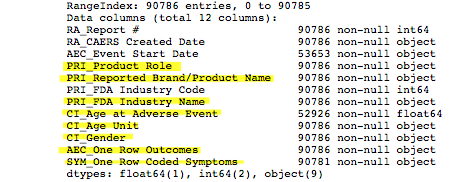

We can reduce the columns down to taking out the ones that don't provide any value to our analysis. We will take out columns: "RA_Report #", "RA_CAERS Created Date", 'AEC_Event Start Date", "PRI_FDA Industry Code", so let's do that:

In [1663]:
df = df[['PRI_Product Role', 'PRI_Reported Brand/Product Name', 'PRI_FDA Industry Name',
        'CI_Age at Adverse Event', 'CI_Age Unit', 'CI_Gender', 'AEC_One Row Outcomes', 
        'SYM_One Row Coded Symptoms']]

In [1664]:
#Look at a clearer subnet of the necessary fields
df.head(5)

,PRI_Product Role,PRI_Reported Brand/Product Name,PRI_FDA Industry Name,CI_Age at Adverse Event,CI_Age Unit,CI_Gender,AEC_One Row Outcomes,SYM_One Row Coded Symptoms
0,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, RASH, WHEEZING, COUGH, HOSPITAL..."
1,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, WHEEZING, COUGH, RASH, HOSPITAL..."
2,Suspect,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,Ice Cream Prod,NaN,Not Available,Female,VISITED AN ER,"NAUSEA, DYSGEUSIA, DIARRHOEA"
3,Suspect,ENFAMIL LIPIL BABY FORMULA,Baby Food Prod,3.0,Month(s),Not Available,NON-SERIOUS INJURIES/ ILLNESS,"GASTROINTESTINAL DISORDER, VOMITING"
4,Suspect,ENFIMIL LIPIL BABY FORMULA,Baby Food Prod,NaN,Not Available,Not Available,VISITED A HEALTH CARE PROVIDER,"GASTROINTESTINAL DISORDER, PHYSICAL EXAMINATION"


In [1665]:
#Let's cleanup the column names
df.columns

Index(['PRI_Product Role', 'PRI_Reported Brand/Product Name',
       'PRI_FDA Industry Name', 'CI_Age at Adverse Event', 'CI_Age Unit',
       'CI_Gender', 'AEC_One Row Outcomes', 'SYM_One Row Coded Symptoms'],
      dtype='object')

In [1666]:
#Renaming the df column names
df.rename(index=str, columns={'PRI_Product Role': 'Product Role',
                              'PRI_Reported Brand/Product Name': 'Brand-Product',
                              'PRI_FDA Industry Name': 'IndustryName',
                              'CI_Age at Adverse Event': 'Age', 
                              'CI_Age Unit': 'Age Unit',
                              'CI_Gender': 'Gender', 
                              'AEC_One Row Outcomes': 'Outcomes',
                              'SYM_One Row Coded Symptoms': 'Symptoms'},  inplace=True)
df.head(5)

,Product Role,Brand-Product,IndustryName,Age,Age Unit,Gender,Outcomes,Symptoms
0,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, RASH, WHEEZING, COUGH, HOSPITAL..."
1,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, WHEEZING, COUGH, RASH, HOSPITAL..."
2,Suspect,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,Ice Cream Prod,NaN,Not Available,Female,VISITED AN ER,"NAUSEA, DYSGEUSIA, DIARRHOEA"
3,Suspect,ENFAMIL LIPIL BABY FORMULA,Baby Food Prod,3.0,Month(s),Not Available,NON-SERIOUS INJURIES/ ILLNESS,"GASTROINTESTINAL DISORDER, VOMITING"
4,Suspect,ENFIMIL LIPIL BABY FORMULA,Baby Food Prod,NaN,Not Available,Not Available,VISITED A HEALTH CARE PROVIDER,"GASTROINTESTINAL DISORDER, PHYSICAL EXAMINATION"


Let's look at each of the columns summary of its contents.

In [1667]:
df['Product Role'].describe()

count       90786
unique          2
top       Suspect
freq        74558
Name: Product Role, dtype: object

In [1668]:
df['Brand-Product'].describe()

count        90786
unique       45685
top       REDACTED
freq          6081
Name: Brand-Product, dtype: object

In [1669]:
df['IndustryName'].describe()

count                                      90786
unique                                        41
top       Vit/Min/Prot/Unconv Diet(Human/Animal)
freq                                       48501
Name: IndustryName, dtype: object

In [1670]:
df['Age'].describe()

count    52926.000000
mean        50.755319
std         23.249385
min          0.000000
25%         35.000000
50%         53.000000
75%         68.000000
max        736.000000
Name: Age, dtype: float64

In [1671]:
df['Age Unit'].describe()

count       90786
unique          6
top       Year(s)
freq        51331
Name: Age Unit, dtype: object

In [1672]:
df['Gender'].describe()

count      90786
unique         5
top       Female
freq       58924
Name: Gender, dtype: object

In [1673]:
df['Outcomes'].describe()

count                             90786
unique                              298
top       NON-SERIOUS INJURIES/ ILLNESS
freq                              24370
Name: Outcomes, dtype: object

In [1674]:
df['Symptoms'].describe()

count              90781
unique             33546
top       OVARIAN CANCER
freq                4572
Name: Symptoms, dtype: object

### Question 1: 
### 'What was the most frequently reported food for allergies and what was the resulting outcome?'

Finding the most reported food may not be that difficult to find as the entries are single in nature. However, this is not so for the 'symptoms, as they are one column that can hold multiple results. Linking the top result for food allergy to the top outcome will require some wrangling of the data and spliting out the AEC_One Row Outcomes columns.

To get the most reported foods outcome, we will need to work backwards as the Outcomes needs to be separated. In order to understand what was the most frequently medical outcome from a reaction to a food allergy, we will first look at the "AEC_One Row Outcomes" individually. We will create a function that takes the schema dataframe and the column as a string, and returns a string of the description for that column.

Once we get the Outcomes splitted into either a list or their own individual columns, we can the just simply sort the new dataset but top food allergy and extract its associated medical outcome.

In [1675]:
#Find the top 25 most reported food for allergies:

df['Brand-Product'].value_counts()[:25]

REDACTED                                                              6081
VITAMIN D                                                              717
MULTIVITAMIN                                                           667
SUPER BETA PROSTATE                                                    648
FISH OIL                                                               622
CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MULTIVITAMINS) TABLET       615
CALCIUM                                                                592
VITAMIN C                                                              479
WEN CLEANSING CONDITIONER                                              372
PETER PAN CREAMY PEANUT BUTTER                                         332
HYDROXYCUT REGULAR RAPID RELEASE CAPLETS                               327
RAW OYSTERS                                                            305
MAGNESIUM                                                              303
VITAMIN D3               

NOTE: As the top reported food seems it come up as 'REDACTED' I cannot find anything in the accompanying README documentation or company website or Internet in general to tell me if this is a product or is an indication of a designation to take literally... ie. as the product is too sensitive and has been 'REDACTED'.  As as result, I will assume it means the latter, and proceed to look at the 2nd most reported food product. 

In [1957]:
df['IndustryName'].value_counts()[:5]

Vit/Min/Prot/Unconv Diet(Human/Animal)    48501
Cosmetics                                 11733
Nuts/Edible Seed                           3383
Vegetables/Vegetable Products              3115
Soft Drink/Water                           2591
Name: IndustryName, dtype: int64

In [1676]:
df['IndustryName'].describe()

count                                      90786
unique                                        41
top       Vit/Min/Prot/Unconv Diet(Human/Animal)
freq                                       48501
Name: IndustryName, dtype: object

In [1677]:
freq_prec = round(df['IndustryName'].describe().loc['freq']/len(df),2)
freq_item = df['IndustryName'].describe().loc['top']
print('Item: {} is comprises about {}% of this dataset.'.format(freq_item, freq_prec))

Item: Vit/Min/Prot/Unconv Diet(Human/Animal) is comprises about 0.53% of this dataset.


If we ignore the 'REDACTED' entries in the 1st place (~7% of our dataset), then the 2nd 'most' reported food reported for allergies is 'Vitamin D'. But in finding this item I notice there are quite a few our foods that are reported as 'vitamins'. Just in the top 25 foods reported 21 were from the Vitamins and other dietary supplement category. Zooming out we look at that category summary this is indeed that vitamins (among other mineral, protiens, and diet products) are playing over half (53%) of all reported food allegies.

Now that we found the top food products and even the general category the fall in. we will need to find what adverse affects those are linked to. Let's look at the 'AEC_One Row Outcomes' column to see how complex its content is.

In [1678]:
df['Outcomes'].value_counts()

NON-SERIOUS INJURIES/ ILLNESS                                                                                                                                 24370
OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)                                                                                                                      19948
VISITED A HEALTH CARE PROVIDER, OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)                                                                                       7948
HOSPITALIZATION                                                                                                                                                5760
VISITED A HEALTH CARE PROVIDER                                                                                                                                 3156
OTHER SERIOUS (IMPORTANT MEDICAL EVENTS), VISITED AN ER                                                                                                        2348
HOSPITALIZATION,

In [1679]:
df['Outcomes'].describe()

count                             90786
unique                              298
top       NON-SERIOUS INJURIES/ ILLNESS
freq                              24370
Name: Outcomes, dtype: object

That is still complex as each entry is comprised of many sub categories. We will need to break these entries to find the basic components.

In [1680]:
#Function the takes in a column that is comprised of multiple string entries in each row.

def create_possible_vals_list(column):
'''
    INPUT: dataframe column with string values 
    OUTPUT:
        1) List of only the individual strings found in that column
        2) Dataframe with the unique value count of the times the 'row entries' were mention in the column

'''

    #Create a dataframe of the value counts of the entries in the column passed
    val_count_df = pd.DataFrame(column.value_counts())


    #Provide a pandas series to hold only the unique values reported
    possible_vals = []

    for string in val_count_df.index:
        split_list = string.split(',')
        num_in_list = len(split_list)
        for i in range(num_in_list):
            if split_list[i][0] == ' ':
                split_list[i] = split_list[i][1:]
                if split_list[i] not in possible_vals:
                    possible_vals.append(split_list[i])

    return possible_vals, val_count_df


In [1681]:
outcome_poss_vals_list, outcome_val_count_df = create_possible_vals_list(df['Outcomes'])

In [1682]:
outcome_val_count_df

,Outcomes
NON-SERIOUS INJURIES/ ILLNESS,24370
OTHER SERIOUS (IMPORTANT MEDICAL EVENTS),19948
"VISITED A HEALTH CARE PROVIDER, OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)",7948
HOSPITALIZATION,5760
VISITED A HEALTH CARE PROVIDER,3156
"OTHER SERIOUS (IMPORTANT MEDICAL EVENTS), VISITED AN ER",2348
"HOSPITALIZATION, VISITED AN ER",2134
"VISITED A HEALTH CARE PROVIDER, NON-SERIOUS INJURIES/ ILLNESS",1625
"OTHER SERIOUS (IMPORTANT MEDICAL EVENTS), HOSPITALIZATION",1623
VISITED AN ER,1511


In [1683]:
outcome_poss_vals_list

['OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)',
 'VISITED AN ER',
 'NON-SERIOUS INJURIES/ ILLNESS',
 'HOSPITALIZATION',
 'VISITED A HEALTH CARE PROVIDER',
 'DISABILITY',
 'SERIOUS INJURIES/ ILLNESS',
 'DEATH',
 'LIFE THREATENING',
 'REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.',
 'CONGENITAL ANOMALY']

We can see a clearer picture now on the mess of the multiple entries in the outcome column. So from all the 90786 rows we have reduced to possible unique 'entries' for outcomes from the 'AEC_One Row Outcomes' column which was 298 which turns out to be only a combination of small dataset of 11 basic choices.

Now we will go back thru the 'outcome_count_df' dataframe and count up all the times each of the 11 possible values appear from the 'possible_vals' list. This will turn out to be a very useful exercise to gather some insight on what is really happening here.

In [1684]:
#Function to create a dict of all the counts that each possible values within a 'column' that
# appears in the value_count dataframe rows

def create_possible_vals_dict(column):
'''
    INPUT: dataframe column with string values 
    OUTPUT:
        1) List of only the individual strings found in that column
        2) Dictionary of a count for each entry in the list
        
'''
    possible_vals_dict = {}
    
    #Create a list of unique values found in the column
    possible_vals_list, possible_val_count_df = create_possible_vals_list(column)

    #Set the dict to size of list and initialize count entries to zero
    for vals in possible_vals_list:
        possible_vals_dict[vals] = 0
        
    
    #Go thru all 'unique values' of the possible_val_count_df dataframe and sum up each 'unique value count'
    # appears from each of the values for the 'possible_vals_list'
    for string in possible_val_count_df.index:
        split_list = string.split(',')
        for phrase in split_list:
            if phrase[0] == ' ':                #Removing a space on some of the entries
                phrase = phrase[1:]
            for vals in possible_vals_list:
                if vals == phrase:
                    possible_vals_dict[vals] += possible_val_count_df.loc[string][0]
                    
    return possible_vals_dict

Now, run our functions on the 'Outcome' to get a dictionary of a list of counts for each core value appears in the column passed.

In [1685]:
outcome_poss_vals_dict = create_possible_vals_dict(df['Outcomes'])
outcome_poss_vals_dict

{'CONGENITAL ANOMALY': 77,
 'DEATH': 2028,
 'DISABILITY': 2890,
 'HOSPITALIZATION': 16908,
 'LIFE THREATENING': 5274,
 'NON-SERIOUS INJURIES/ ILLNESS': 27835,
 'OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)': 36837,
 'REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.': 2944,
 'SERIOUS INJURIES/ ILLNESS': 3606,
 'VISITED A HEALTH CARE PROVIDER': 20158,
 'VISITED AN ER': 12890}

In [1910]:
#Function to plot a dictionary and show the sorted dictionary values

def plot_values_dict(vals_dict, percent=0, plot=True, sums=False, c='b'):
'''
    INPUT: 
        1) Dictionary with counts of individual string values 
        2) Percent - of how much of the list should be shown, default=0%
        3) Plot flag - to display, default=True
        4) Sums - print the sum of all the displayed values, default=False
        5) c - colour flag on the bar plot colour, default=blue
        
    OUTPUT:
        1) Displayed list with their count of values from vals_dict
        2) Print out of sum of all the displayed values
        3) Bar plot of keys and values from vals_dict 

'''
    dict_for_plot = {} 
    top_ttl_results = 0
    
    a = vals_dict
    sorted_vals_dict = sorted(a.items(), key=lambda item: item[1], reverse=True)
    cutoff = int(len(vals_dict)*(1-percent))      #Get the % cutoff value as most of the list is below this value

    print("The values that are above the {} results reported cutoff".format(cutoff))
    print('\n')
    for ii, (key, value) in enumerate(sorted_vals_dict):
#        if int(value) > cutoff:

        if ii < cutoff:
            print("{:>4}:  {:<45}: {:=5}".format(ii, key, value))
            
            dict_for_plot[key] = value            #making a new dictionary just for plotting
            top_ttl_results += value

    if sums:
        print('\n')
        print("The sum of these values is: {}".format(top_ttl_results))
    
    if plot:
        #Plot the possible values:
        plt.bar(range(len(dict_for_plot)), list(dict_for_plot.values()), align='center', color=c)
        plt.xticks(range(len(dict_for_plot)), list(dict_for_plot.keys()), rotation='vertical')
        plt.show()
        


The values that are above the 11 results reported cutoff


   0:  OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)     : 36837
   1:  NON-SERIOUS INJURIES/ ILLNESS                : 27835
   2:  VISITED A HEALTH CARE PROVIDER               : 20158
   3:  HOSPITALIZATION                              : 16908
   4:  VISITED AN ER                                : 12890
   5:  LIFE THREATENING                             :  5274
   6:  SERIOUS INJURIES/ ILLNESS                    :  3606
   7:  REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.    :  2944
   8:  DISABILITY                                   :  2890
   9:  DEATH                                        :  2028
  10:  CONGENITAL ANOMALY                           :    77


The sum of these values is: 131447


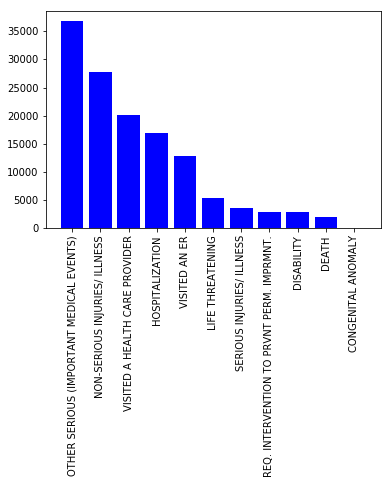

In [1911]:
#Sort and plot the results in our 11 output counts
plot_values_dict(outcome_poss_vals_dict, sums=True)

Now that we have found the entries that are most reported we need to find how these reported outcomes link to which food allergy. To do that we need to break up the 'AEC_One Row Outcomes' into 11 possible outcome (ie. one for each of the possible outcomes).

In [1912]:
#Function to separate each unique value found in the column passed and returns a new dataFrame with 
# the shape of (rows in df column size x possible values in that column) to hold 
# all possible results after splitting into their individual phrases

def split_col_field(column):    
'''
    INPUT: 
        1) Dataframe column mixed values you want to get unique values
        
    OUTPUT:
        1) Dataframe with one column for each unique entry found within the passed dataframe column

'''
    poss_vals_list, val_count_df = create_possible_vals_list(column)
#    sorted_vals_dict = create_possible_vals_dict(column)   
    
    numRows = df.shape[0]
    numCols= len(poss_vals_list)

    a = np.zeros(shape=(numRows, numCols))
    df_subset = pd.DataFrame(a,columns=poss_vals_list, index=df.index)

    #For each multiple listings in column split into phrases
    for i, entry in enumerate(column):  
        split_entry = entry.split(',')
        for phrase in split_entry:
            if phrase[0] == ' ':                #Removing a space on some of the entries
                phrase = phrase[1:]
                
            df_subset.iloc[i][phrase] = 1;      #Place a '1' in the column that matches for each row
            
    return df_subset


In [1913]:
#Split out the Outcomes into its own column for each unique entry with a '1' for every occurance found
# in the original column

df_outcomes = split_col_field(df['Outcomes'])
df_outcomes.head(10)

,OTHER SERIOUS (IMPORTANT MEDICAL EVENTS),VISITED AN ER,NON-SERIOUS INJURIES/ ILLNESS,HOSPITALIZATION,VISITED A HEALTH CARE PROVIDER,DISABILITY,SERIOUS INJURIES/ ILLNESS,DEATH,LIFE THREATENING,REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.,CONGENITAL ANOMALY
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1914]:
df2 = pd.concat([df, df_outcomes], axis=1)   #Concatenate df_subset to the original df 
df2 = df2.drop('Outcomes', axis=1)   #Drop the old column since we don't need it any longer
df2.shape 

(90786, 18)

In [1915]:
df2.head(5)

,Product Role,Brand-Product,IndustryName,Age,Age Unit,Gender,Symptoms,OTHER SERIOUS (IMPORTANT MEDICAL EVENTS),VISITED AN ER,NON-SERIOUS INJURIES/ ILLNESS,HOSPITALIZATION,VISITED A HEALTH CARE PROVIDER,DISABILITY,SERIOUS INJURIES/ ILLNESS,DEATH,LIFE THREATENING,REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.,CONGENITAL ANOMALY
0,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"SWELLING FACE, RASH, WHEEZING, COUGH, HOSPITAL...",0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"SWELLING FACE, WHEEZING, COUGH, RASH, HOSPITAL...",0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Suspect,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,Ice Cream Prod,NaN,Not Available,Female,"NAUSEA, DYSGEUSIA, DIARRHOEA",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Suspect,ENFAMIL LIPIL BABY FORMULA,Baby Food Prod,3.0,Month(s),Not Available,"GASTROINTESTINAL DISORDER, VOMITING",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Suspect,ENFIMIL LIPIL BABY FORMULA,Baby Food Prod,NaN,Not Available,Not Available,"GASTROINTESTINAL DISORDER, PHYSICAL EXAMINATION",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we have the dataset colums for report food and all unique medical outcomes in their own columns we can do a simple query to find top food reported and see the outcome it is linked to.

The values that are above the 41 results reported cutoff


   0:  Vit/Min/Prot/Unconv Diet(Human/Animal)       : 48501
   1:  Cosmetics                                    : 11733
   2:  Nuts/Edible Seed                             :  3383
   3:  Vegetables/Vegetable Products                :  3115
   4:  Soft Drink/Water                             :  2591
   5:  Bakery Prod/Dough/Mix/Icing                  :  2543
   6:  Fishery/Seafood Prod                         :  2382
   7:  Fruit/Fruit Prod                             :  2239
   8:  Milk/Butter/Dried Milk Prod                  :  1515
   9:  Dietary Conv Food/Meal Replacements          :  1420
  10:  Cereal Prep/Breakfast Food                   :  1264
  11:  Baby Food Prod                               :  1264
  12:  Mult Food Dinner/Grav/Sauce/Special          :  1016
  13:  Snack Food Item                              :   996
  14:  Coffee/Tea                                   :   872
  15:  Ice Cream Prod                    

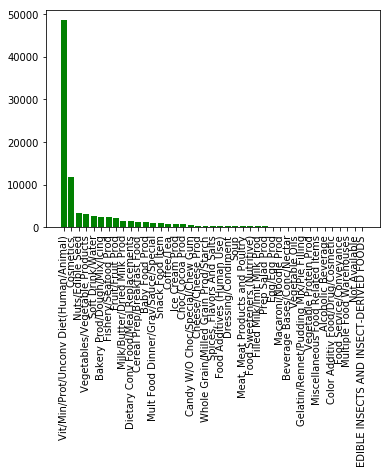

In [1916]:
#Get all counts of unique values that appear in 'Industry Name' product columns

industryfood_dict = df2['IndustryName'].value_counts().to_dict()
plot_values_dict(industryfood_dict, sums=True, c='g')

In [1917]:
Vitamin_cat_percent = round(industryfood_dict['Vit/Min/Prot/Unconv Diet(Human/Animal)']/len(df2)*100,1)
print("The percent of reported allergies for the 'vitamin/mineral..etc. category is {}%".format(Vitamin_cat_percent))

The percent of reported allergies for the 'vitamin/mineral..etc. category is 53.4%


As we mentioned before and see from above, it is clear that the 'Vit/Min/Prot/Unconv Diet(Human/Animal)' category is by far the dominate reported industry (53% of the whole dataset) so we should concentrate our analysis here even though there some interesting questions we could still ask about the other 39 categories as it pertains to the eleven outcomes but for the limit of this project (blog) we save that for another analysis.

We now have to somehow group all the reported outcomes for each of the Industry products that were reported with a food allergy. We are really only interested in the food that had the highest reports, which in this case is definitely surrounding the vitamins/minerals category (ie. 'Vit/Min/Prot/Unconv Diet(Human/Animal)'). We can see from above it has over 48,000 reports (over 50%) of our total dataset (90786 rows). We will now want to see how that category (Vitamins/Min.....) was distributed over all the 11 outcomes and see what was the highest.

In [1918]:
#Function to plot the total mentions of all Outcomes for a particular Industry Name

def plot_outcome_by_industry (industryName, c='blue'):

    query_str = "IndustryName ==" +"'"+industryName+"'"

    topIndustry_by_outcomes_dict = {}
    for outcome in outcome_poss_vals_list:
        topIndustry_by_outcomes_dict[outcome] = 0

    for outcome in outcome_poss_vals_list:
        count = df2.query(query_str)[outcome].sum()
        topIndustry_by_outcomes_dict[outcome] = count


    plot_values_dict(topIndustry_by_outcomes_dict, sums=True, c=c)

The values that are above the 11 results reported cutoff


   0:  OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)     : 28350.0
   1:  HOSPITALIZATION                              : 13951.0
   2:  VISITED A HEALTH CARE PROVIDER               : 10061.0
   3:  VISITED AN ER                                : 8218.0
   4:  NON-SERIOUS INJURIES/ ILLNESS                : 3736.0
   5:  LIFE THREATENING                             : 3686.0
   6:  SERIOUS INJURIES/ ILLNESS                    : 3354.0
   7:  DISABILITY                                   : 1814.0
   8:  REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.    : 1687.0
   9:  DEATH                                        : 755.0
  10:  CONGENITAL ANOMALY                           :  53.0


The sum of these values is: 75665.0


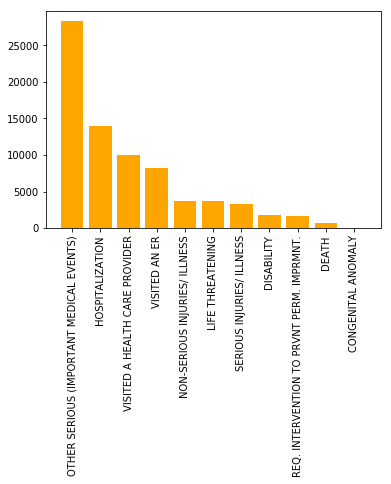

In [1919]:
#Sort and plot how the 2nd top category: Vitamins/Minerals category rows distribute over the 11 outcomes
plot_outcome_by_industry ('Vit/Min/Prot/Unconv Diet(Human/Animal)',c='orange')

The values that are above the 11 results reported cutoff


   0:  OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)     : 6371.0
   1:  VISITED A HEALTH CARE PROVIDER               : 5082.0
   2:  NON-SERIOUS INJURIES/ ILLNESS                : 2923.0
   3:  DEATH                                        : 969.0
   4:  VISITED AN ER                                : 577.0
   5:  HOSPITALIZATION                              : 564.0
   6:  DISABILITY                                   : 397.0
   7:  REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.    : 183.0
   8:  LIFE THREATENING                             : 158.0
   9:  SERIOUS INJURIES/ ILLNESS                    :  50.0
  10:  CONGENITAL ANOMALY                           :   3.0


The sum of these values is: 17277.0


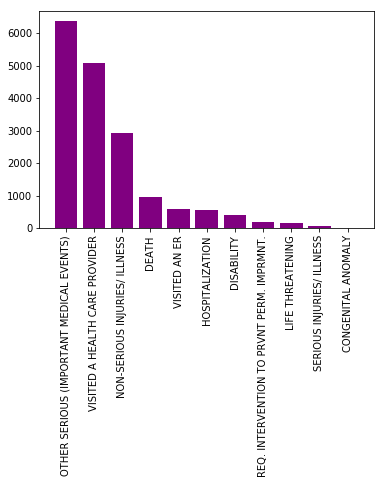

In [1920]:
#Sort and plot how the 3rd top category: 'Cosmetics' category rows distribute over the 11 outcomes
plot_outcome_by_industry ('Cosmetics', c='purple')

The values that are above the 20 results reported cutoff


   0:  Cosmetics                                    : 969.0
   1:  Vit/Min/Prot/Unconv Diet(Human/Animal)       : 755.0
   2:  Fishery/Seafood Prod                         :  96.0
   3:  Dietary Conv Food/Meal Replacements          :  77.0
   4:  Baby Food Prod                               :  40.0
   5:  Nuts/Edible Seed                             :  18.0
   6:  Soft Drink/Water                             :  14.0
   7:  Bakery Prod/Dough/Mix/Icing                  :  13.0
   8:  Vegetables/Vegetable Products                :  11.0
   9:  Cheese/Cheese Prod                           :   6.0
  10:  Ice Cream Prod                               :   5.0
  11:  Food Additives (Human Use)                   :   5.0
  12:  Fruit/Fruit Prod                             :   4.0
  13:  Candy W/O Choc/Special/Chew Gum              :   2.0
  14:  Food Sweeteners (Nutritive)                  :   2.0
  15:  Alcoholic Beverage                

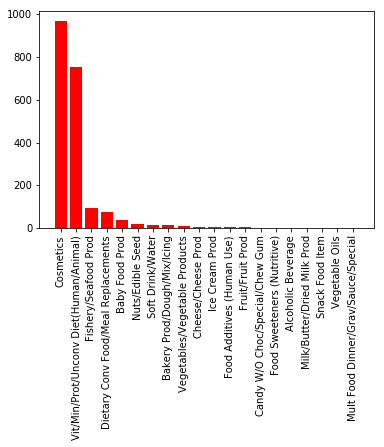

In [1922]:
df3 = df2.groupby('IndustryName')['DEATH'].sum() 
death_by_industrydict = df3.sort_values(ascending=False).to_dict()

plot_values_dict(death_by_industrydict, 0.5, sums=True, c='red')

So what we see above is we have drilled down from looking at over 48,000 rows that pertain to the 'Vitamin, Minerals...etc. category and within those rows we have divided how that category reflects in our 11 reported outcomes. We see the highest reported Outcome by far is 'Other Serious (Important Medical Events)' with a whopping 28,350 reported mentions. 

We also did the same for the 'Cosmetics' and noticed there were 6,371 times it was linked to the 'Other Serious (Important Medical Events)' outcome which is only a 22% of the mentions of the 'Vitamins/Supplement' category. Something interesting to note here, when analyzing 'vitamins' the outcome of 'death' was reported only ~1% of the time (and lands in 10th or 11th spot on the ranking above). However, when we switch to 'Cosmetics' we see that death rate rise to ~6% (and lands 4th of 11th ranking above). This is quite an interesting find as we normally hear so much on food allergies and vital or lethal affects but here was see vitamins (which can still be considered a 'food') and products that are not the normal items we would normally associate with 'food allergies.

Note to make here, this number is not a reflection of only the 'rows' in the dataset but rather the the count whenever this outcome was 'mentioned' in Outcomes column, recall that in the original outcome column it allowed for multiple for entries in this field, we then divided those in their own columns so one row can have one or more outcomes associated with it. Hence, the sum total mentioned above (ie. 75,665) is not a count of rows in dataset but rather the total 'mentions' all these outcomes appear. Clear as mud? ;-)


We can even take this farther and dig deeper in this one category to see of all the Vitamins/Minerals...etc., which one was the highest reported that for serious and non-serious outcomes.

In [1923]:
#Recalling what the 11 outcomes from the allergic reactions are
outcome_poss_vals_list

['OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)',
 'VISITED AN ER',
 'NON-SERIOUS INJURIES/ ILLNESS',
 'HOSPITALIZATION',
 'VISITED A HEALTH CARE PROVIDER',
 'DISABILITY',
 'SERIOUS INJURIES/ ILLNESS',
 'DEATH',
 'LIFE THREATENING',
 'REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.',
 'CONGENITAL ANOMALY']

Let's just focus on the top 2 outcomes ('Other Serious-important medical events' and 'Death') to see what were the top 'food' products that results for the 'Vitamin' and 'Cosmetic' categories.

In [1924]:
#Query top product in the vitamins/supplements that reported outcomes of Other Serious or Death
outcome_subset = ['OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)','DEATH']
for cols in outcome_subset:
    
    df4 = pd.DataFrame(df2[df2[cols] == 1.0]  \
                .query("IndustryName == 'Vit/Min/Prot/Unconv Diet(Human/Animal)'")  \
                .groupby('Brand-Product')[cols].sum()) 
    df4 = df4.sort_values(by=cols, ascending=0)
       
    display(df4.head(1))

,OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)
Brand-Product,
"CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MULTIVITAMINS) TABLET",574.0


,DEATH
Brand-Product,
BENEFIBER WITH WHEAT DEXTRIN (NCH) (WHEAT DEXTRIN) POWDER,11.0


In [1925]:
#Query top product in the Cosmetics that reported outcomes of Other Serious or Death
outcome_subset = ['OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)','DEATH']
for cols in outcome_subset:
    
    df4 = pd.DataFrame(df2[df2[cols] == 1.0]  \
                .query("IndustryName == 'Cosmetics'")  \
                .groupby('Brand-Product')[cols].sum()) 
    df4 = df4.sort_values(by=cols, ascending=0)
       
    display(df4.head(2))

,OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)
Brand-Product,
REDACTED,4214.0
WEN CLEANSING CONDITIONER,192.0


,DEATH
Brand-Product,
REDACTED,939.0
SHOWER TO SHOWER POWDER,6.0


We can see "Centrum Silver Women 50+" was the top vitamin/supplement reported that resulted in 'other serious or important medical events' while the "Benefiber with Wheat Powder" was the top product in that same category that resulted/reported as an outcome as 'death'.

Moving to the cosmetic category, we see "Wen Cleansing Conditioner" was the top cosmetic product reported that resulted in 'other serious or important medical events' while the "Shower to Shower Powder" was the top product in that same category that resulted/reported as an outcome as 'death'.

As mentioned before but still worth analyzing here, the product that is labelled 'REDACTED' was omitted from this analysis but if were to include those products they would far out weigh the ones mentioned above.

### Question 2: 
### 'What was the most reported food allergies symptom?'

Now, let's look at the items in the Symptoms to see if we can do the same as we did we the Outcomes column items.

In [1926]:
symptom_poss_vals_list, symptom_val_count_df = create_possible_vals_list(df2['Symptoms'])
symptom_val_count_df

,Symptoms
OVARIAN CANCER,4572
CHOKING,1797
DIARRHOEA,1345
VOMITING,1005
ALOPECIA,975
NAUSEA,754
MALAISE,660
DYSGEUSIA,657
"DIARRHOEA, VOMITING",546
"DYSPHAGIA, CHOKING",488


Looks like Ovarian Cancer is the top single reported symptom when it comes to reporting on this dataset of food allergies, but is this really the top reported or is this symptom lost when other symptoms are reported amongst others.

In [1927]:
#We can look at the length of the unique symptoms reported and see the list is over 300x larger then the list of the 
# possible Outcomes, so its best not to print out the whole list

len(symptoms_poss_vals_list)

3857

Let's just see if the dictionary of the sorted UNIQUE values printed can give us some insights

In [1928]:
#plot_values_dict(symptom_poss_vals_dict, 0, plot=False)        

WOW! That list is long and it really starts to drop to single digits very quickly. To make this visual more appealing let's see what the top 70% of the reported symptoms are compared to the whole list of unique symptom values

The values that are above the 38 results reported cutoff


   0:  DIARRHOEA                                    : 15542
   1:  VOMITING                                     : 13329
   2:  NAUSEA                                       : 11816
   3:  ABDOMINAL PAIN                               :  9270
   4:  MALAISE                                      :  6497
   5:  CHOKING                                      :  5922
   6:  DYSPNOEA                                     :  5795
   7:  HEADACHE                                     :  5708
   8:  HYPERSENSITIVITY                             :  5311
   9:  DIZZINESS                                    :  5109
  10:  ABDOMINAL PAIN UPPER                         :  4941
  11:  ALOPECIA                                     :  4882
  12:  OVARIAN CANCER                               :  4780
  13:  PRURITUS                                     :  4478
  14:  PAIN                                         :  4105
  15:  FATIGUE                           

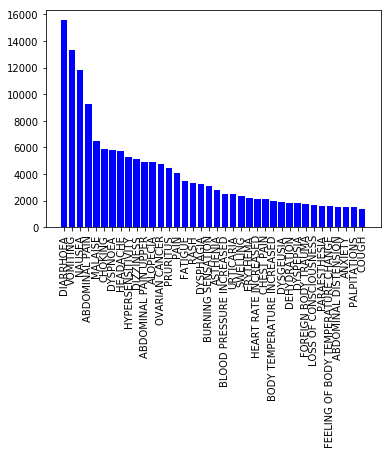

In [1933]:
plot_values_dict(symptom_poss_vals_dict, 0.99, sums=True)   #use cutoff of 99%

So we can see 70% of the unique values lay within only 46 of the top reported symptoms. That would mean over 3800 of the 3857 reported symptoms fall into the rest of the 30% values. And we can see that Ovarian Cancer seems to fall way back to 12th most reported symptom once we account for all reported symptoms individually.

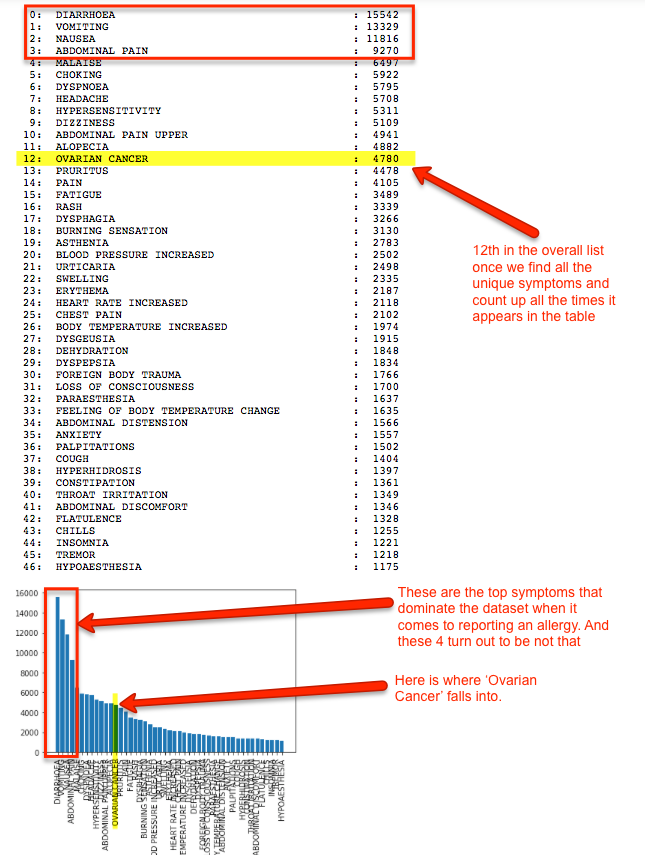

In [1934]:
#Find the reported counts of 'Death' in the dictionary on 'unique' symptoms:
symptom_poss_vals_dict['DEATH']

458

In [1935]:
#Find the reported counts of 'Death' in the dictionary on 'unique' symptoms:
symptom_poss_vals_dict['OVARIAN CANCER']

4780

In [1936]:
#Find the reported counts of 'Death' in the dictionary on 'unique' symptoms:
symptom_poss_vals_dict['DIARRHOEA']

15542

Now that we have a sorted list of the individual reported symptoms, we can see the top reported symptom 'Diarrhoea' is 3x more reported then 'Ovarian Cancer' and almost 34x more then 'Death'. 

In [1937]:
pd.DataFrame(df2.query("IndustryName == 'Cosmetics'").groupby('Brand-Product')[cols].sum()) 

,DEATH
Brand-Product,
AMLACTIN LOTION,0.0
BLACK HENNA,0.0
INDIVIDUAL EYELASHES,0.0
P & G PUFFS PUFFS PLUS LOTION WITH A SCENT OF VICKS FACIAL TISSUES,0.0
SHEA BUTTER,0.0
VEET HAIR REMOVAL CREAM SENSITIVE,0.0
WEN CLEANSING CONDITONER,0.0
"100% BEST BENTONITE CLAY, 100 POUNDS",0.0
100% PURE BENTONITE FINE POWDER,0.0


### Question 3: 
### What foods result in death for ‘elderly’ vs. the same reactions for ‘young' people?

In [1938]:
df2.columns

Index(['Product Role', 'Brand-Product', 'IndustryName', 'Age', 'Age Unit',
       'Gender', 'Symptoms', 'OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)',
       'VISITED AN ER', 'NON-SERIOUS INJURIES/ ILLNESS', 'HOSPITALIZATION',
       'VISITED A HEALTH CARE PROVIDER', 'DISABILITY',
       'SERIOUS INJURIES/ ILLNESS', 'DEATH', 'LIFE THREATENING',
       'REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.', 'CONGENITAL ANOMALY'],
      dtype='object')

To answer this question, I would need to look at the following:

- Prime columns: 'Age', 'Age Unit'  'Brand-Product', 'IndustryName',
- Secondary columns: 'Product Role', 'Gender'

In [1939]:
#Lets start looking at the 'Age Unit' field to see what their unique values are.

df2['Age Unit'].value_counts()

Year(s)          51331
Not Available    37873
Month(s)          1253
Week(s)            174
Day(s)             147
Decade(s)            8
Name: Age Unit, dtype: int64

Interesting that some people reported their ages in 'decades'. Lets look at these 8 entries and see if have the right input to convert into proper age in years.

In [1940]:
df2[df2['Age Unit'] == 'Decade(s)']

,Product Role,Brand-Product,IndustryName,Age,Age Unit,Gender,Symptoms,OTHER SERIOUS (IMPORTANT MEDICAL EVENTS),VISITED AN ER,NON-SERIOUS INJURIES/ ILLNESS,HOSPITALIZATION,VISITED A HEALTH CARE PROVIDER,DISABILITY,SERIOUS INJURIES/ ILLNESS,DEATH,LIFE THREATENING,REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.,CONGENITAL ANOMALY
2209,Suspect,OCEAN BREEZE RAW OYSTERS,Fishery/Seafood Prod,76.0,Decade(s),Male,"DEATH, GASTROENTERITIS VIBRIO",0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
46364,Suspect,"IMEDEEN TIME PERFECTION (ACEROLA EXTRACT, FISH...",Vit/Min/Prot/Unconv Diet(Human/Animal),7.0,Decade(s),Female,"DIABETES MELLITUS, BLOOD GLUCOSE ABNORMAL, DIA...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48041,Suspect,"CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MUL...",Vit/Min/Prot/Unconv Diet(Human/Animal),6.0,Decade(s),Female,"HYPERTENSION, FEAR, DYSPHAGIA, CHOKING",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48544,Suspect,"CENTRUM SILVER (MULTIMINERALS, MULTIVITAMINS) ...",Vit/Min/Prot/Unconv Diet(Human/Animal),8.0,Decade(s),Female,"RHEUMATOID ARTHRITIS, GASTRITIS, GASTROOESOPHA...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49851,Suspect,"CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MUL...",Vit/Min/Prot/Unconv Diet(Human/Animal),6.0,Decade(s),Female,"FALL, CHOKING",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51567,Suspect,CENTRUM SILVER WOMENS 50+ MULTIMINERALS MULTI...,Vit/Min/Prot/Unconv Diet(Human/Animal),8.0,Decade(s),Female,"DYSPHAGIA, CHOKING",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80764,Suspect,"CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MUL...",Vit/Min/Prot/Unconv Diet(Human/Animal),9.0,Decade(s),Female,DEATH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
83344,Suspect,"CENTRUM (MULTIMINERALS, MULTIVITAMINS) TABLET",Vit/Min/Prot/Unconv Diet(Human/Animal),6.0,Decade(s),Female,"DYSPHAGIA, CHOKING",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Yup, as we can see, there is one person on row 2209 that reported or mistakenly selected 'decades' to report his age. We should correct that now.

In [1941]:
#df2.iloc[2209].replace('Decade(s)', 'Year(s)', inplace=True)
#df2.iloc[2209].replace(to_replace=r'^Decade.$', value='Year(s)', regex=True)
#df2.iloc[2209]['Age Unit']
#.replace(to_replace='Decade(s)', value='Year(s)', regex=True)
df2.replace({'Age Unit': 2209}, 'Year(s)', inplace=True)

In [1942]:
df2.iloc[2209]

Product Role                                                       Suspect
Brand-Product                                     OCEAN BREEZE RAW OYSTERS
IndustryName                                          Fishery/Seafood Prod
Age                                                                     76
Age Unit                                                         Decade(s)
Gender                                                                Male
Symptoms                                     DEATH, GASTROENTERITIS VIBRIO
OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)                                 0
VISITED AN ER                                                            1
NON-SERIOUS INJURIES/ ILLNESS                                            0
HOSPITALIZATION                                                          0
VISITED A HEALTH CARE PROVIDER                                           1
DISABILITY                                                               0
SERIOUS INJURIES/ ILLNESS

In [1943]:
#Trying to make convert the months to years change permenant but this doesn't seem to be working
for i, units in enumerate(df2['Age Unit']):
    if units == 'Month(s)':
        old_age = df2.iloc[i]['Age']
        new_age = round(old_age/12,2)
        df2.replace({'Age': i}, new_age, inplace=True, regex=True)
        df2.replace({'Age Unit': str(i)}, 'Year(s)', inplace=True, regex=True)        

In [1947]:
df2[df2['Age Unit'] == 'Month(s)']

,Product Role,Brand-Product,IndustryName,Age,Age Unit,Gender,Symptoms,OTHER SERIOUS (IMPORTANT MEDICAL EVENTS),VISITED AN ER,NON-SERIOUS INJURIES/ ILLNESS,HOSPITALIZATION,VISITED A HEALTH CARE PROVIDER,DISABILITY,SERIOUS INJURIES/ ILLNESS,DEATH,LIFE THREATENING,REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.,CONGENITAL ANOMALY
3,Suspect,ENFAMIL LIPIL BABY FORMULA,Baby Food Prod,0.25,Month(s),Not Available,"GASTROINTESTINAL DISORDER, VOMITING",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,Suspect,"CRYSTAL SPRING WATER WATER,NURSERY FLUORODATED",Soft Drink/Water,15.00,Month(s),Male,"ABDOMINAL PAIN, LOOSE STOOLS, DIARRHOEA, FLATU...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,Suspect,EARTH'S BEST TEETHING BISCUITS,Baby Food Prod,5.00,Month(s),Female,CHOKING,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,Suspect,DARIGOLD VITAMIN D WHOLE MILK,Milk/Butter/Dried Milk Prod,18.00,Month(s),Female,"STOOLS WATERY, ABNORMAL BEHAVIOUR, FEELING ABN...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213,Suspect,PARENT'S CHOICE BABY SHAMPOO,Cosmetics,9.00,Month(s),Male,"EYE REDNESS, EYE PAIN, SCREAMING",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,Suspect,NURSERY PURIFIED WATER WITH CHLORIDE,Baby Food Prod,8.00,Month(s),Female,"DIARRHOEA, EYE SWELLING",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
363,Suspect,FRITO LAY ROLD GOLD PRETZELS,Snack Food Item,19.00,Month(s),Female,"EMERGENCY CARE EXAMINATION, VOMITING, ABDOMINA...",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
445,Suspect,REDACTED,Baby Food Prod,11.00,Month(s),Male,"NAUSEA, VOMITING",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
471,Suspect,BEECHNUT NATURAL RICE CEREAL FOR BABY SOY FREE...,Baby Food Prod,8.00,Month(s),Male,"MALAISE, VOMITING",0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
491,Suspect,MEAD JOHNSON LIPIL,Baby Food Prod,7.00,Month(s),Not Available,"FAECES DISCOLOURED, VOMITING PROJECTILE, CONST...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


NOTE: Not sure why but I can't seem to use 'implace' or assignment to make the replace function permenant. This will make it hard to display the correct analysis. As a result, I will proceed to analyze this dataset taking into account this issue and make a decision which rows to accept at the end.

In [1948]:
#First we need to fill NaN's in the Age columns in order to do any sorting
df2['Age'].fillna(0, inplace=True)
df2['Age'].value_counts()

0.0      37874
70.0       967
58.0       965
60.0       950
62.0       942
50.0       918
65.0       914
52.0       889
57.0       887
56.0       881
55.0       881
69.0       874
59.0       873
64.0       851
53.0       846
61.0       842
67.0       840
63.0       824
54.0       823
73.0       804
66.0       803
68.0       797
75.0       790
74.0       773
42.0       772
47.0       746
49.0       728
72.0       708
37.0       708
45.0       705
         ...  
17.0       236
15.0       226
13.0       222
90.0       217
1.0        203
12.0       160
91.0       141
92.0        96
93.0        78
94.0        66
95.0        43
97.0        35
96.0        30
98.0        15
100.0        6
99.0         6
104.0        4
736.0        3
101.0        2
103.0        2
167.0        2
112.0        1
115.0        1
151.0        1
102.0        1
250.0        1
117.0        1
135.0        1
156.0        1
155.0        1
Name: Age, Length: 115, dtype: int64

We can see we have replaced nearly 38,000 NaN rows (or >40%) with zeros. 

The values that are above the 10 results reported cutoff


   0:  Baby Food Prod                               :  26.0
   1:  Dietary Conv Food/Meal Replacements          :  14.0
   2:  Vit/Min/Prot/Unconv Diet(Human/Animal)       :  12.0
   3:  Milk/Butter/Dried Milk Prod                  :   2.0
   4:  Nuts/Edible Seed                             :   2.0
   5:  Soft Drink/Water                             :   1.0
   6:  Bakery Prod/Dough/Mix/Icing                  :   0.0
   7:  Beverage Bases/Conc/Nectar                   :   0.0
   8:  Candy W/O Choc/Special/Chew Gum              :   0.0
   9:  Cereal Prep/Breakfast Food                   :   0.0


The sum of these values is: 57.0


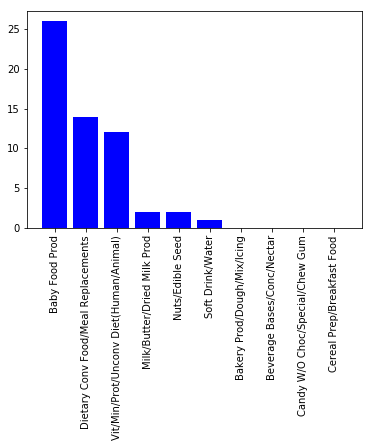

In [1949]:
#Filter list on ages that would be under 10 years (which includes age units of years, months, weeks or days and 
#  excludes decades) for industryNames that resulted in a 'Death' outcome.

young_death_dict = pd.DataFrame(df2[(df2['Age'] <=10.0) & 
                                    (df2['Age Unit'] != 
                                     ('Not Available' or 'Decade(s)'))]). \
              groupby('IndustryName')['DEATH'].sum().to_dict()
plot_values_dict(young_death_dict, 0.7, sums=True)

The values that are above the 27 results reported cutoff


   0:  SIMPLY THICK                                 :   5.0
   1:  4LIFE TRANSFER FACTOR TRI FACTOR             :   1.0
   2:  ALASKA INSTANT MILK POWDER                   :   1.0
   3:  BABYS CHOICE GENTLE INFANT FORMULA POWDER    :   1.0
   4:  BENEPROTEIN POWDER (NESTLE)                  :   1.0
   5:  CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MULTIVITAMINS) TABLET:   1.0
   6:  D-VITA                                       :   1.0
   7:  DEL MONTE QUALITY NATURES GOODNESS RICE #1 BEGINNERS:   1.0
   8:  ENFAMIL ENFACARE                             :   1.0
   9:  ENFAMIL ENFACARE LIPIL (POWDERED FORMULA) FOR CONDITIONS SUCH AS PREMATURITY AND LOW BIRTH WEIGHT:   1.0
  10:  ENFAMIL GENTLEASE LIPIL POWDERED INFANT FORMULA:   1.0
  11:  ENFAMIL LIPIL MILK-BASED INFANT FORMULA, IRON FORTIFIED:   1.0
  12:  ENFAMIL LIPIL WITH IRON MILK-BASED INFANT FORMULA CONCENTRATE (LIQUID):   1.0
  13:  ENFAMIL PREMIUM INFANT POWDER FORMULA  

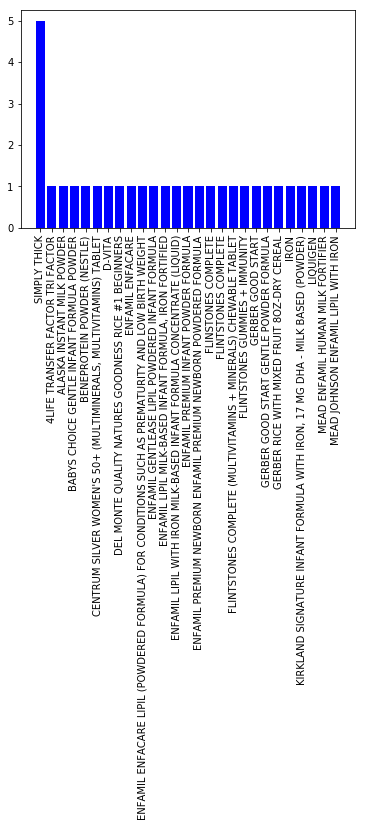

In [1951]:
#Filter list on ages that would be under 10 years (which includes age units of years, months, weeks or days and 
#  excludes decades) for Product Brands that resulted in a 'Death' outcome within this list above.

young_death_dict = pd.DataFrame(df2[(df2['Age'] <=10.0) & 
                                    (df2['Age Unit'] != 
                                     ('Not Available' or 'Decade(s)'))]). \
              groupby('Brand-Product')['DEATH'].sum().to_dict()
plot_values_dict(young_death_dict, 0.99, sums=True)

The values that are above the 19 results reported cutoff


   0:  Vit/Min/Prot/Unconv Diet(Human/Animal)       : 329.0
   1:  Cosmetics                                    : 198.0
   2:  Fishery/Seafood Prod                         :  66.0
   3:  Dietary Conv Food/Meal Replacements          :  28.0
   4:  Bakery Prod/Dough/Mix/Icing                  :   9.0
   5:  Nuts/Edible Seed                             :   9.0
   6:  Vegetables/Vegetable Products                :   5.0
   7:  Ice Cream Prod                               :   3.0
   8:  Soft Drink/Water                             :   2.0
   9:  Baby Food Prod                               :   1.0
  10:  Candy W/O Choc/Special/Chew Gum              :   1.0
  11:  Egg/Egg Prod                                 :   1.0
  12:  Food Additives (Human Use)                   :   1.0
  13:  Fruit/Fruit Prod                             :   1.0
  14:  Soup                                         :   1.0
  15:  Alcoholic Beverage                

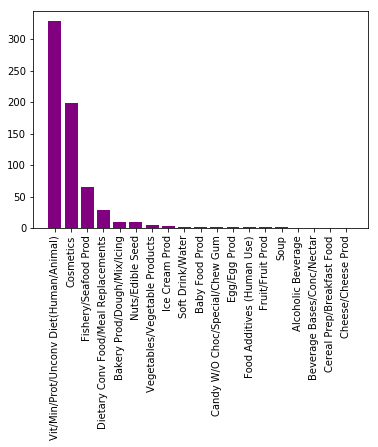

In [1953]:
#Filter list on ages that would be over 50 years (which includes age units of years but excludes units of
#  months, weeks or days and decades) for industryNames that resulted in a 'Death' outcome.


older_death_dict = pd.DataFrame(df2[(df2['Age'] >=50.0) & (df2['Age Unit'] 
                                                           != ('Not Available' or 'Decade(s)' or
                                                               'Month(s)' or 'Week(s)' or 'Day(s)'))]). \
              groupby('IndustryName')['DEATH'].sum().to_dict()
plot_values_dict(older_death_dict, 0.5, sums=True, c='purple')

The values that are above the 14 results reported cutoff


   0:  REDACTED                                     : 196.0
   1:  RAW OYSTERS                                  :  32.0
   2:  AXONA                                        :   9.0
   3:  BENEFIBER WITH WHEAT DEXTRIN (NCH) (WHEAT DEXTRIN) POWDER:   9.0
   4:  OYSTERS                                      :   4.0
   5:  RAW CLAMS                                    :   4.0
   6:  BENEFIBER                                    :   3.0
   7:  BENEFIBER UNKNOWN (NCH)                      :   3.0
   8:  BENEFIBER UNKNOWN (NCH) (UNKNOWN) UNKNOWN    :   3.0
   9:  FISH OIL                                     :   3.0
  10:  POTASSIUM                                    :   3.0
  11:  PROTANDIM US                                 :   3.0
  12:  REUMOFAN PLUS                                :   3.0
  13:  VITAMIN C                                    :   3.0


The sum of these values is: 278.0


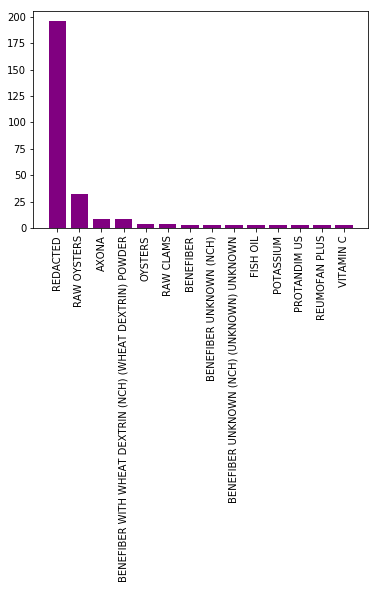

In [1956]:
#Filter list on ages that would be over 50 years (which includes age units of years but excludes units of
#  months, weeks or days and decades) for Brand Names that resulted in a 'Death' outcome.


older_death_dict = pd.DataFrame(df2[(df2['Age'] >=50.0) & (df2['Age Unit'] 
                                                           != ('Not Available' or 'Decade(s)' or
                                                               'Month(s)' or 'Week(s)' or 'Day(s)'))]). \
              groupby('Brand-Product')['DEATH'].sum().to_dict()
plot_values_dict(older_death_dict, 0.999, sums=True, c='purple')

We see the top industry and top brand product that resulted in deaths for youth under ten (10) years and younger was  'Baby Food Prod' and 'SIMPLY THICK' respectively. And we We see the top industry and top brand product that resulted in deaths for older people over fifty (50) years was  'Vit/Min/Prot/Unconv Diet(Human/Animal)' and 'RAW OYSTERS' respectively. Note, the product in ''old' group is 2nd most reactive product after 'REDACTED' which we skipped as that product doesn't add any useful context to the product.

Conclusion, we can see the industries and brand products that are related to deaths in young pertain to products that would be ones that would mostly likely associated with one that mothers would be giving to infants. And the contrast there is a totally separate set of products that relate to death in 'older' people as these products would rarely be used for the same age group. 

Note, here is that the conclusion is slightly skewed in the numbers towards the elderly (ie. looks like more older people are more susceptible to food allergies. But this is not case and is more likely the result on been able to replace and clean the age units correctly. Having a more homogeneous age units in years would result in a more accurate analysis, but I feel this rough analysis was sufficient to provide a general insight to the products to avoid in both the young and the elderly.

In [ ]:
#pd.DataFrame(df2.query("IndustryName == 'Cosmetics'").groupby('Brand-Product')[cols].sum()) 

### Resources

1) Transfer Factor - https://en.m.wikipedia.org/wiki/Transfer_factor